In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Download, read in, preprocess data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=False)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=False)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [6]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3031,2017-11-22,25.7,0.0,0.6,0.2,22.7,23.9
3034,2017-11-22,47.0,3.0,0.0,0.3,24.8,29.9
3031,2017-11-23,55.4,25.7,0.0,0.6,0.2,22.7
3034,2017-11-23,53.1,47.0,3.0,0.0,0.3,24.8
3007,2017-11-29,9.3,14.4,5.7,0.3,0.0,2.9
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [7]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(25)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.0,0.1,0.3,0.900,1.7
3007,2020-04-30,6280.500,0.0,0.0,0.2,1.300,1.5
3009,2020-04-30,6280.900,0.0,0.0,0.3,1.200,1.6
3010,2020-04-30,6280.500,0.0,0.0,0.2,1.100,2.2
3011,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.0
3012,2020-04-30,6280.500,0.0,0.0,0.0,0.300,0.7
3013,2020-04-30,6280.858,0.0,0.0,0.1,0.600,1.1
3014,2020-04-30,6280.500,0.0,0.0,0.0,0.200,0.1
3015,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.1


In [8]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [10]:
labels = labels.drop(drop_idx)

In [11]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12970, 5238)
Shape of labels    :  (12970, 69)


In [12]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

**Why do we want to do feed in weather data to a neural network when other data is available?** This is a good question. Generally, we cannot send people everywhere to inspect avalanche conditions. That means that there are many places where the *only* data that we have available comes in the form of weather forecasts and observations. Thus, it is important to see if a model can predict danger level or the first avalanche problem given only weather data.

In [13]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    #df.drop(col_list, axis=1, inplace=True)
    return df

In [14]:
def sum_over_features(df, col_list, new_name, drop=False):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [15]:
def take_max(df, col_list, new_name, drop=False):
    """
    Create a column for the max value given over the past 3 days (72 hours).
    This will drop the input columns in col_list if drop is set to True.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for creating the max value
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
    
    Returns:
        df(DataFrame): same input data frame with new max value column
    """
    # take the max over rows
    df[new_name] = df.loc[:, col_list].max(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [16]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [17]:
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
all_wx_cols = [col for col in regions.columns]

for drop_col in dont_include_list:
    all_wx_cols = [col for col in all_wx_cols if drop_col not in col]

all_wx_cols

['precip_most_exposed_0',
 'precip_most_exposed_1',
 'precip_most_exposed_2',
 'precip_most_exposed_3',
 'precip_most_exposed_4',
 'precip_most_exposed_5',
 'precip_0',
 'precip_1',
 'precip_2',
 'precip_3',
 'precip_4',
 'precip_5',
 'wind_speed_0',
 'wind_speed_1',
 'wind_speed_2',
 'wind_speed_3',
 'wind_speed_4',
 'wind_speed_5',
 'wind_change_speed_0',
 'wind_change_speed_1',
 'wind_change_speed_2',
 'wind_change_speed_3',
 'wind_change_speed_4',
 'wind_change_speed_5',
 'temp_min_0',
 'temp_min_1',
 'temp_min_2',
 'temp_min_3',
 'temp_min_4',
 'temp_min_5',
 'temp_max_0',
 'temp_max_1',
 'temp_max_2',
 'temp_max_3',
 'temp_max_4',
 'temp_max_5',
 'temp_lev_0',
 'temp_lev_1',
 'temp_lev_2',
 'temp_lev_3',
 'temp_lev_4',
 'temp_lev_5',
 'temp_freeze_lev_0',
 'temp_freeze_lev_1',
 'temp_freeze_lev_2',
 'temp_freeze_lev_3',
 'temp_freeze_lev_4',
 'temp_freeze_lev_5',
 'wind_speed_max_0',
 'wind_speed_max_1',
 'wind_speed_max_2',
 'wind_speed_max_3',
 'wind_speed_max_4',
 'wind_speed_

In [18]:
train = regions.loc[:, all_wx_cols]
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,769.990,18.5,5.5,0.0,5.5,0.0,0.0,24.0,26.3,-3.5
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,1138.400,18.5,9.0,5.5,9.0,0.0,0.0,33.0,50.0,-2.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,731.790,15.5,18.5,5.5,0.0,5.5,0.0,39.5,81.1,3.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,1128.605,18.5,18.5,9.0,5.5,9.0,0.0,46.0,103.1,3.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,44.970,12.0,12.0,5.5,12.0,12.0,23.0,29.5,29.4,-4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


In [19]:
# to_include = [col for col in regions.columns if '72hr' in col]
# train = regions.loc[:, to_include]
# train

In [20]:
def scale_input_data(X):
    """
    Scale input features from [-1, 1] so that it is easier to
    train a neural network.
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X)
    return scaled

In [21]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,0.300168,0.005038,0.010915,0.003359,0.231738,0.245172,0.268828,0.000000,0.006276,0.002092,...,0.307996,0.616667,0.183333,0.000000,0.183333,0.000000,0.000000,0.289157,0.172140,0.471109
3034,2017-11-22,0.473552,0.041142,0.000000,0.002519,0.241814,0.302267,0.491632,0.031381,0.000000,0.003138,...,0.455360,0.616667,0.300000,0.183333,0.300000,0.000000,0.000000,0.397590,0.327262,0.504165
3031,2017-11-23,0.669186,0.300168,0.005038,0.010915,0.003359,0.231738,0.579498,0.268828,0.000000,0.006276,...,0.292716,0.516667,0.616667,0.183333,0.000000,0.183333,0.000000,0.475904,0.530818,0.614351
3034,2017-11-23,0.553317,0.473552,0.041142,0.000000,0.002519,0.241814,0.555439,0.491632,0.031381,0.000000,...,0.451442,0.616667,0.616667,0.300000,0.183333,0.300000,0.000000,0.554217,0.674813,0.614351
3007,2017-11-29,0.081444,0.141898,0.060453,0.005877,0.000000,0.028547,0.097280,0.150628,0.059623,0.003138,...,0.017988,0.400000,0.400000,0.183333,0.400000,0.400000,0.766667,0.355422,0.192430,0.457887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.000000,0.083963,0.125945,0.167926,0.016793,0.000000,0.000000,0.052301,0.104603,0.156904,...,0.000000,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054
3032,2021-01-12,0.000000,0.016793,0.050378,0.041982,0.000000,0.000000,0.000000,0.000000,0.031381,0.020921,...,0.000000,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905
3034,2021-01-12,0.016793,0.067170,0.167926,0.167926,0.000000,0.000000,0.000000,0.041841,0.125523,0.104603,...,0.000000,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979


In [22]:
print(np.any(np.isnan(train)))

False


In [23]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3031,2017-11-22,4
3034,2017-11-22,4
3031,2017-11-23,4
3034,2017-11-23,4
3007,2017-11-29,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


In [24]:
np.unique(train_labels)

array([1, 2, 3, 4])

In [25]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
1                     19.06
2                     52.10
3                     26.66
4                      2.18
dtype: float64

So we see that there is a heavy imbalance in the class weights that we are trying to predict. This is not ideal for our case, because more than anything we need to reliably be able to predict danger levels 3 and 4. Scikit-learn makes this easy to do for imbalanced classification tasks.

In [27]:
flat_values = [value[0] for value in train_labels.values]
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_values),
                                            flat_values)

print(weights)

[ 1.31169094  0.47987272  0.93768074 11.45759717]


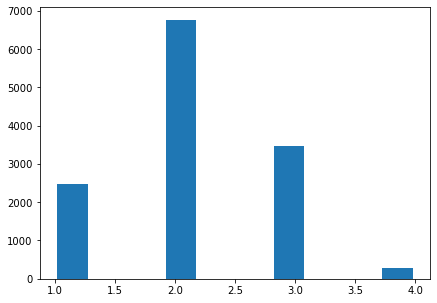

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(flat_values, rwidth=0.85)
plt.show()

In [29]:
class_weights = {
    0: 2.5,
    1: 1,
    2: 2,
    3: 10
}

# Split data

In [30]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [31]:
print(len(train_idx), len(X_train), len(y_train))
print(len(val_idx), len(X_val), len(y_val))
print(len(test_idx), len(X_test), len(y_test))

16 16 16
3 3 3
3 3 3


In [32]:
print(np.any(np.isnan(np.concatenate(X_train))))
print(np.any(np.isnan(np.concatenate(y_train))))
print(np.any(np.isnan(np.concatenate(X_val))))
print(np.any(np.isnan(np.concatenate(y_val))))

False
False
False
False


In [33]:
# let's exame one region's time series
plotx = X_train[0]
ploty = y_train[0]

# our created features are the last three columns
wind = plotx[:, -3]
precip = plotx[:, -2]
temp = plotx[:, -1] 

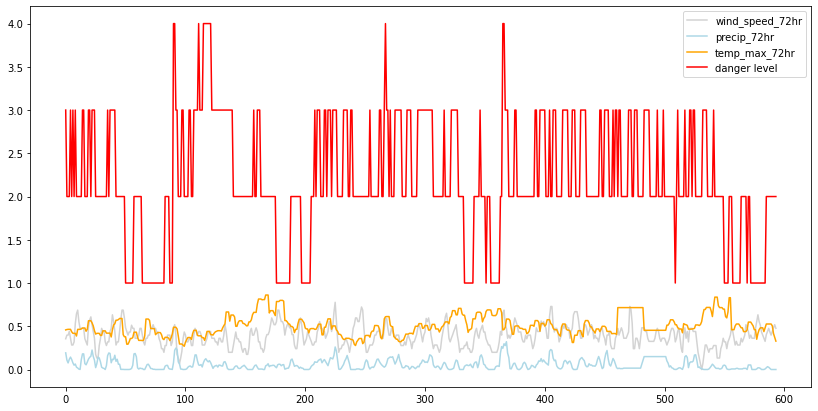

In [34]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(wind, color='lightgrey', label='wind_speed_72hr')
ax.plot(precip, color='lightblue', label='precip_72hr')
ax.plot(temp, color='orange', label='temp_max_72hr')
ax.plot(ploty, color='r', label='danger level')

ax.legend()
plt.show()

Below, you will see that each input data-label pair (representing one region) have the same number of rows (observations), and that there are > 300 observations for some regions. This is because we are stacking multiple seasons together for the same region.

In [35]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(594, 57) (594, 1)
(594, 57) (594, 1)
(594, 57) (594, 1)
(594, 57) (594, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)
(595, 57) (595, 1)
(593, 57) (593, 1)
(341, 57) (341, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)


In [36]:
for (arr, label) in zip(X_val, y_val):
    print(arr.shape, label.shape)

(594, 57) (594, 1)
(593, 57) (593, 1)
(593, 57) (593, 1)


In [37]:
for (arr, label) in zip(X_test, y_test):
    print(arr.shape, label.shape)

(174, 57) (174, 1)
(592, 57) (592, 1)
(595, 57) (595, 1)


In [38]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    #padded = np.concatenate([to_add, arr])
    
    return padded

In [39]:
sequence_length = 14 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [40]:
for (arr, label) in zip(X_train_pad, y_train_pad):
    print(arr.shape, label.shape)

(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)
(350, 57) (350, 1)
(602, 57) (602, 1)
(602, 57) (602, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [41]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train)
y_concat_train = np.concatenate(y_train)

X_concat_val = np.concatenate(X_val)
y_concat_val = np.concatenate(y_val)

print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(9242, 57)
(9242, 1)
(1780, 57)
(1780, 1)


In [42]:
def batch_data(x, y, length):
    """
    Batch the neural network data, creating a shifting window of data at each time step.
    """    
    #create empty lists to append to
    X, Y = [], []
    
    #iterate over dataset, looking at moving window of 1 timestep
    #need to length to prevent out of bounds errors
    for i in range(0, len(x)-length):
        x_batch = x[i:length+i]
        y_batch = y[length+i]
        
        #append batches to lists
        X.append(x_batch)
        Y.append(y_batch)
    
    #convert lists to numpy arrays before turning into torch tensors
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    print(X.shape, Y.shape)
    return X, Y

In [43]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)

(9228, 14, 57) (9228, 1)
(1766, 14, 57) (1766, 1)


In [44]:
print(np.any(np.isnan(batchX_train)))
print(np.any(np.isnan(batchY_train)))
print(np.any(np.isnan(batchX_val)))
print(np.any(np.isnan(batchY_val)))

False
False
False
False


We also need to add a dimension to the un-windowed dataset for it to work properly in TensorFlow. The data should be shaped like so: (samples, sequence length, number of features).

In [45]:
X_concat_train = np.expand_dims(X_concat_train, 1)
X_concat_val = np.expand_dims(X_concat_val, 1)

In [46]:
print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(9242, 1, 57)
(9242, 1)
(1780, 1, 57)
(1780, 1)


# Training a neural network

## Day-of data vs. windowed data

We a hypothesis: that the order of the data that we are feeding to the neural network matters. That is, there is some temporal nature between the input weather data and the resulting danger level or first avalanche problem. To test this, we can first train a neural network on un-windowed data, i.e., data from the data of. Next, we can see if the data improves when we feed it the windowed data.

### Day-of DNN

We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [45]:
def create_dnn(X, n_input, dropout, n_output, add_reg=False):
    """
    Create a DNN with or without regularization. Note: X should have
    shape (samples, timesteps, features)
    """
    timesteps = X.shape[1]
    features = X.shape[2]
    
    # design network
    dnn = tf.keras.models.Sequential()
    if(add_reg == True):
        reg = tf.keras.regularizers.l2(l=0.0001)
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg, input_shape=(timesteps, features)))
        dnn.add(Dropout(dropout))
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg))
        dnn.add(Dropout(dropout))
        
    else:
        dnn.add(Dense(n_input, activation='elu', input_shape=(timesteps, features)))
        dnn.add(Dropout(dropout))
        dnn.add(Dense(n_input, activation='elu'))
        dnn.add(Dropout(dropout))
    
    dnn.add(tf.keras.layers.Flatten())
    dnn.add(Dense(n_output, activation='softmax'))
    
    return dnn

I have decided to use the ELU activation function in the dense layers of both the DNNs and RNNs that I am using in this Notebook. It has the advantage of not being prone to dying neurons that can happen with the ReLU activation function since all negative values are set to 0.

For a brief explanation and visualization of the ELU function I suggest reading this resource: https://deeplearninguniversity.com/elu-as-an-activation-function-in-neural-networks/

In [46]:
input_neurons = 100
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

dayof_dnn = create_dnn(X_concat_train, input_neurons, drop, output_neurons)
dayof_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 100)            5800      
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 100)            10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 16,304
Trainable params: 16,304
Non-trainable params: 0
____________________________________________________

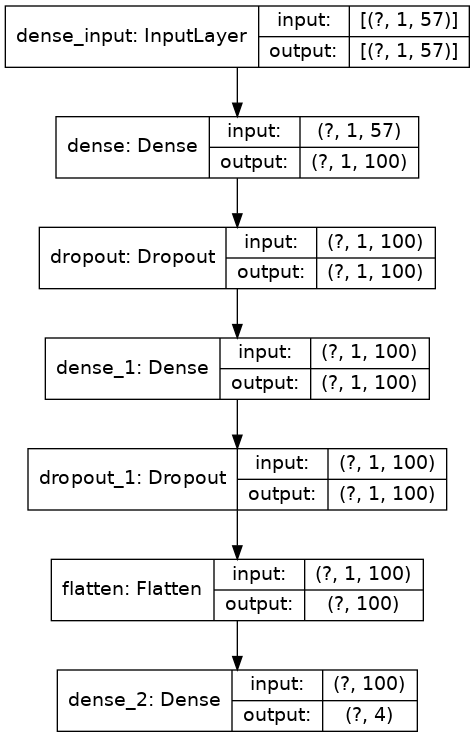

In [47]:
# being able to print model architectures in tensorflow is
# dependent on having pydot and graphviz packages installed
tf.keras.utils.plot_model(dayof_dnn, 'dnn_architecture.png', show_shapes=True)

In [48]:
def train(model, X, y, X_val, y_val, loss, opt, batch, e, w):
    """
    Train a neural network with passed in hyperparameters.
    """
    # compile and fit model
    model.compile(loss=loss, 
                  optimizer=opt, 
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(X, y, validation_data=(X_val, y_val),
                        batch_size=batch, epochs=e, verbose=0, 
                        shuffle=False, class_weight=w)
    
    return history

Below, I have used sparse categorical crossentropy as my loss function instead of plain old categorical crossentropy. My understanding of why this is useful is that you don't need to one-hot encode your labels. So instead of having n-columns in your output labels for n labels, you can instead use a single vector (which is how our labels are formatted). Alongside that, you should use sparse categorical accuracy instead of accuracy in your reporting metrics.

**Important**: for a loss function of (sparse) categorical crossentropy to work, your labels need to include 0. For danger level, the scale goes from 1-4 so we need to remap them to be 0-3. That is why I am subtracting 1 from the danger level labels below.

In [49]:
# specify hyperparams here
num_epochs = 400
alpha = 1e-3
batch_size = 32
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

dayof_dnn_history = train(dayof_dnn, X_concat_train, y_concat_train-1, 
                          X_concat_val, y_concat_val-1, criterion, optimizer, 
                          batch_size, num_epochs, class_weights)

In [50]:
def plot_history(history):
    """
    Plot the loss function vs epochs and metric vs epochs after
    training a neural network.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # plot loss over time
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='val')
    
    # plot metric over time
    ax[1].plot(history.history['sparse_categorical_accuracy'], label='train')
    ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='val')
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].legend()
    ax[1].legend()
    plt.show()

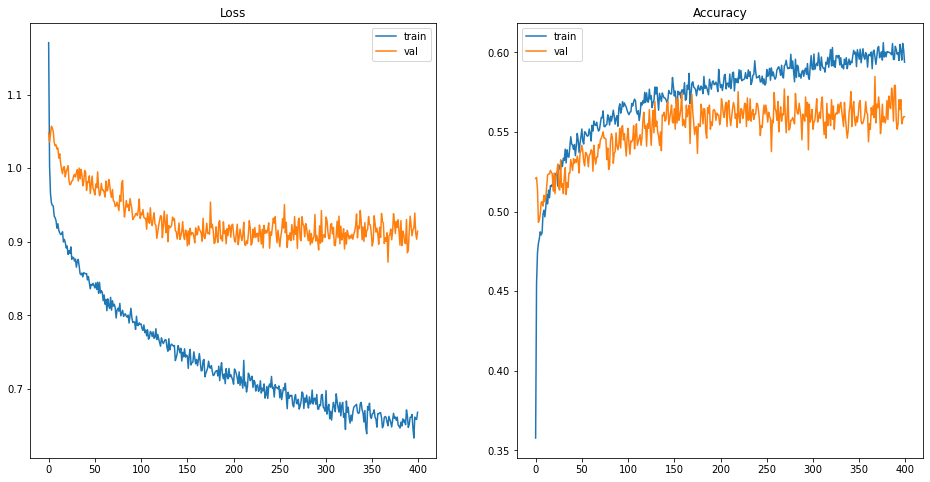

In [51]:
plot_history(dayof_dnn_history)

We could actually continue to run this network to improve the performance if we used some regularization. Both the training and validation loss are continuing to decrease. If regularization makes it so that continue to not overfit, we could then train for longer or train a bigger neural network.

Reference: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

Let's try adding regularization and see what effect that has.

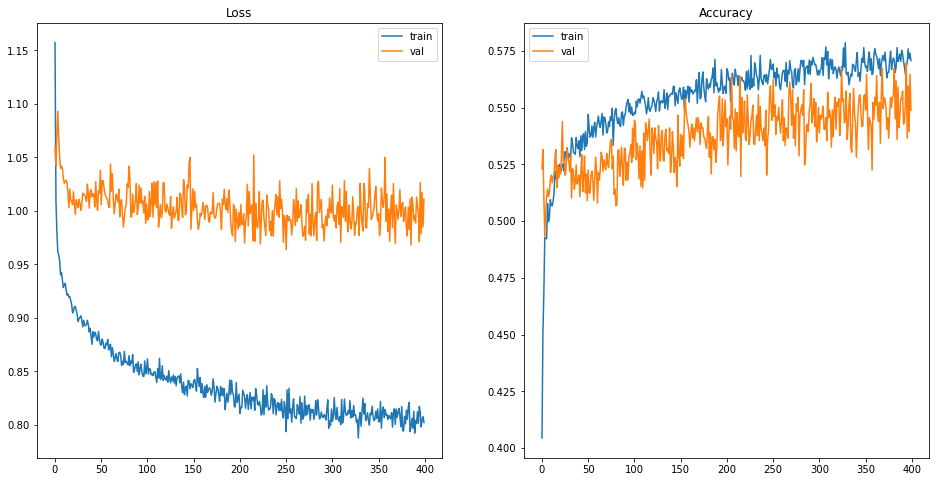

In [52]:
dayof_dnn_reg = create_dnn(X_concat_train, input_neurons, drop, output_neurons, True)

dayof_dnn_reg_history = train(dayof_dnn_reg, X_concat_train, y_concat_train-1, 
                              X_concat_val, y_concat_val-1, criterion, optimizer, 
                              batch_size, num_epochs, class_weights)

plot_history(dayof_dnn_reg_history)

This is not that great of accuracy, but that could improve with hyperparameters tuning and being able to train longer. Regularization actually made our accuracy worse, and we are closer to overfitting.

### Windowed-data DNN

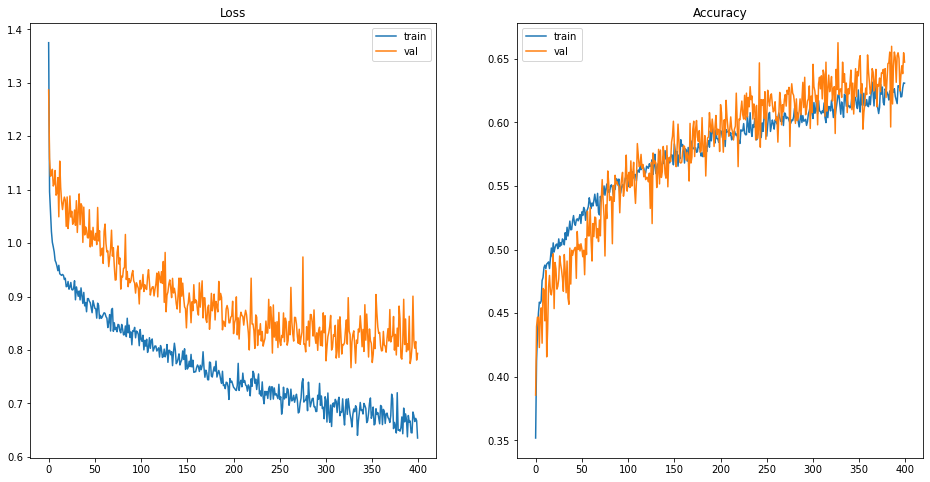

In [53]:
window_dnn = create_dnn(batchX_train, input_neurons, drop, output_neurons)

window_dnn_history = train(window_dnn, batchX_train, batchY_train-1, 
                           batchX_val, batchY_val-1, criterion, optimizer, 
                           batch_size, num_epochs, class_weights)

plot_history(window_dnn_history)

Again we are close to overfitting, although the accuracy curves look much better for the validation set. And now with regularization?

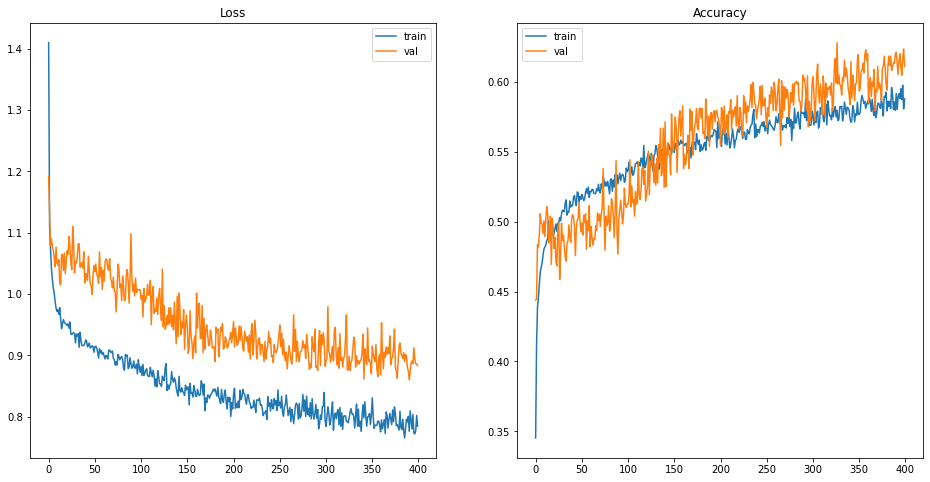

In [54]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train(window_dnn_reg, batchX_train, batchY_train-1, 
                               batchX_val, batchY_val-1, criterion, optimizer, 
                               batch_size, num_epochs, class_weights)

plot_history(window_dnn_reg_history)

**DNN Summary**: In general, networks with L2 regularization in the dense layers performed worse. The windowed dataset worked the best for a (terrible) validation set accuracy of ~60%. However, I think the DNN would work better with more layers or a higher learning rate. The loss curves are encouraging for the window-data DNN, though, and I think we should continue playing with hyperparameters for it.

### Day-of LSTM
We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [51]:
def create_rnn(X, n_input, n_dense, dropout, n_output, add_reg=False):
    """
    Create a RNN with or without regularization. Note: X should have
    shape (samples, timesteps, features)
    """
    timesteps = X.shape[1]
    features = X.shape[2]
    
    # design network
    rnn = tf.keras.models.Sequential()
    
    if(add_reg == True):
        reg = tf.keras.regularizers.l2(l=0.0001)
        rnn.add(Bidirectional(LSTM(input_neurons, kernel_regularizer=reg), input_shape=(timesteps, features)))
        rnn.add(Dense(n_dense, kernel_regularizer=reg, activation='elu'))
        
    else:
        rnn.add(Bidirectional(LSTM(input_neurons), input_shape=(timesteps, features)))
        rnn.add(Dense(n_dense, activation='elu'))
    
    rnn.add(Dropout(dropout))
    rnn.add(Dense(output_neurons, activation='softmax'))
    
    return rnn

In [67]:
input_neurons = 4
dense_neurons = 10

dayof_rnn = create_rnn(X_concat_train, input_neurons, dense_neurons, drop, output_neurons)
dayof_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 8)                 1984      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                90        
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 44        
Total params: 2,118
Trainable params: 2,118
Non-trainable params: 0
_________________________________________________________________


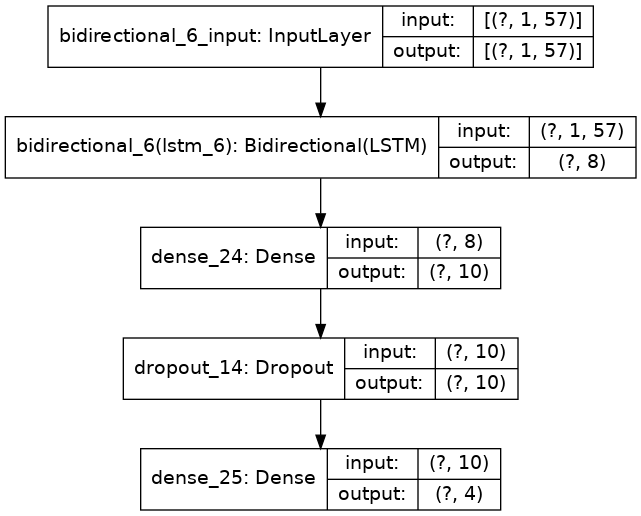

In [68]:
tf.keras.utils.plot_model(dayof_rnn, 'lstm_architecture.png', show_shapes=True)

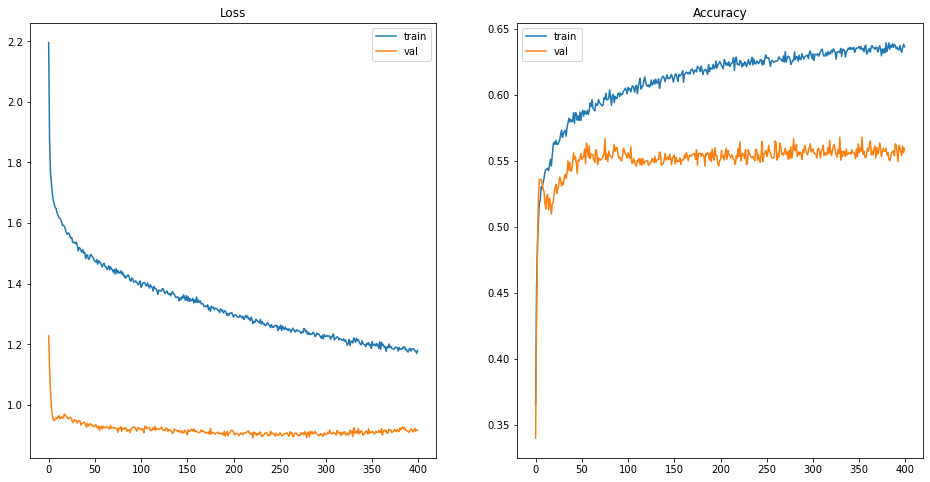

In [69]:
dayof_rnn_history = train(dayof_rnn, X_concat_train, y_concat_train-1, 
                          X_concat_val, y_concat_val-1, criterion, optimizer, 
                          batch_size, num_epochs, class_weights)

plot_history(dayof_rnn_history)

Now let's try regularization.

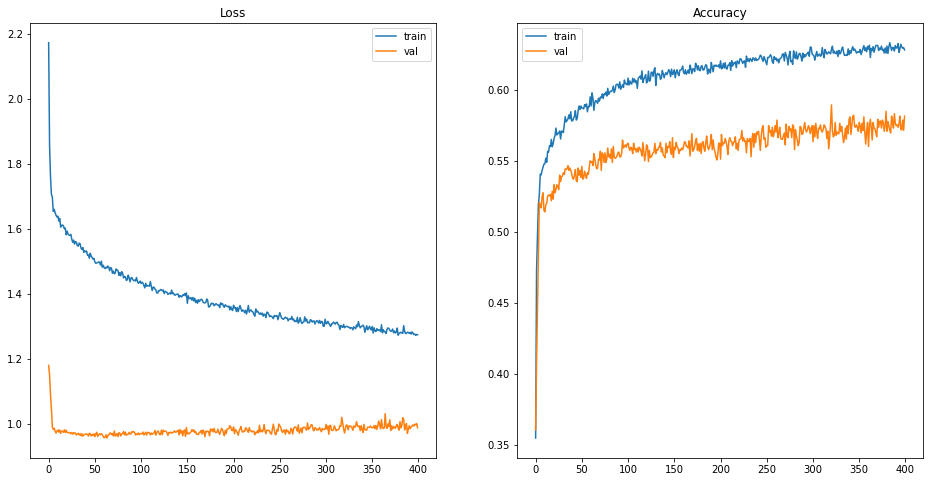

In [70]:
dayof_rnn_reg = create_rnn(X_concat_train, input_neurons, dense_neurons, drop, output_neurons, True)

dayof_rnn_reg_history = train(dayof_rnn_reg, X_concat_train, y_concat_train-1, 
                              X_concat_val, y_concat_val-1, criterion, optimizer, 
                              batch_size, num_epochs, class_weights)

plot_history(dayof_rnn_reg_history)

### Windowed-data LSTM

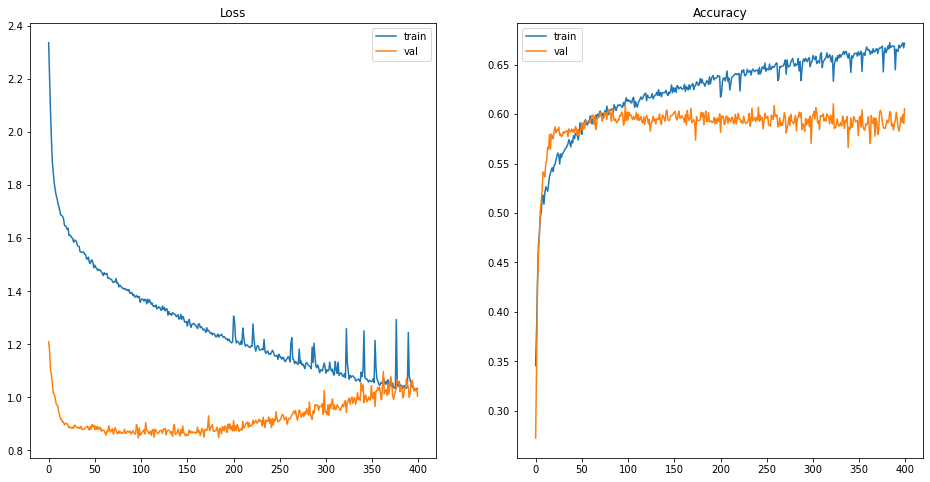

In [53]:
window_rnn = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons)

window_rnn_history = train(window_rnn, batchX_train, batchY_train-1, 
                           batchX_val, batchY_val-1, criterion, optimizer, 
                           batch_size, num_epochs, class_weights)

plot_history(window_rnn_history)

This looks like a classic case of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Our validation loss starts increasing and our training loss continues decreasing. We could try to fix this with trying to add regularization to our network, or using a different architecture (maybe with less layers or neurons per layer).

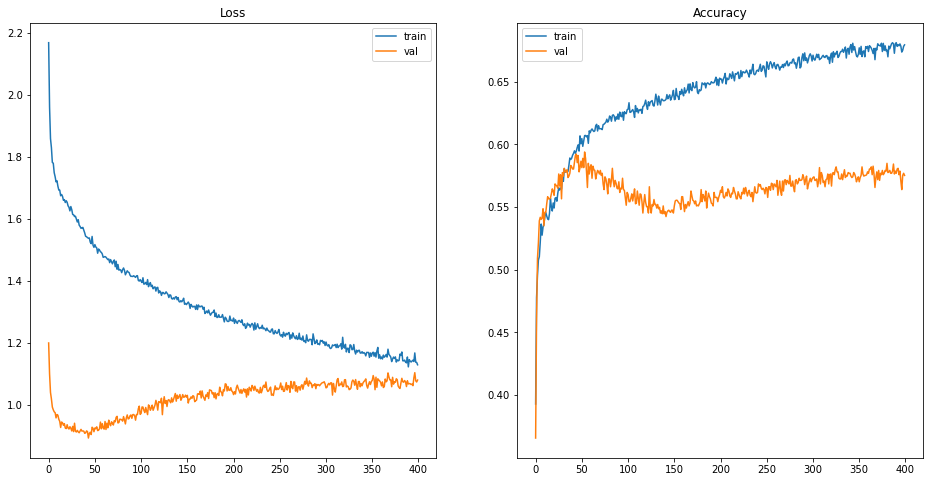

In [54]:
window_rnn_reg = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons, True)

window_rnn_reg_history = train(window_rnn_reg, batchX_train, batchY_train-1, 
                               batchX_val, batchY_val-1, criterion, optimizer, 
                               batch_size, num_epochs, class_weights)

plot_history(window_rnn_reg_history)

**RNN Summary**: In the RNN case, we get a boost in performance if we use a window dataset with L2 regularization.

## Thoughts
- I need to look into what happens when I turn off dropout layers.
- I wonder what would happen if we fed in the danger level (or avalanche problem #1) labels from the previous day in adition to the meteorological variables?
- I would also like to try hyperparameter optimization with [`hyperopt`](https://hyperopt.github.io/hyperopt/).